In [35]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import ftfy
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "dbd.puc-rio.br"
full_url = "https://www.dbd.puc-rio.br/"
site_path = "/sitenovo"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        print("link: " + link)
        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
             
            clean_link = "https://" + local_domain + "/" + link            

        
        if clean_link is not None:
            print("clean_link: " + clean_link)
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc + site_path

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)



In [ ]:
crawl(full_url)

In [39]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('\t', ' ')
    serie = serie.str.replace('\r', ' ')
    new_serie = []
    for row in serie:
        row = ftfy.fix_encoding(row)
        new_serie.append(row)

    return new_serie

In [40]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + site_path + "/"):
    # Open the file and read the text
    with open("text/" + domain + site_path + "/" + file, "r") as f:
        text = f.read()

        # get the page name(dbd exclusive formula!)
        # www.dbd.puc-rio.br_sitenovo__area-restrita.php.txt
        start_index = file.rindex('_') + 1
        end_index = file.index('.', start_index)        
        fname = file[start_index:end_index]
        if(fname == ""):
            fname = "home"

        texts.append((fname, text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.tail(50)

/tmp/ipykernel_3073/1432941642.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
33,comunidade-puc,comunidade-puc. Comunidade PUC DBD ...
34,fale-conosco,fale-conosco. Fale Conosco DBD P...
35,libris,libris. EX-LIBRIS
36,salas-de-estudo,salas-de-estudo. Salas de Estudo DBD ...
37,destaques,destaques. Destaques DBD PUC-Rio ...
38,redes,redes. Redes DBD PUC-Rio pesqui...
39,destaques,destaques. Destaques DBD PUC-Rio ...
40,destaques,destaques. Destaques DBD PUC-Rio ...
41,destaques,destaques. Destaques DBD PUC-Rio ...
42,reserva,reserva. Reserva DBD PUC-Rio pe...


In [48]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [50]:
df['text'].to_csv('text.csv', index=False, header=False)

<AxesSubplot: >

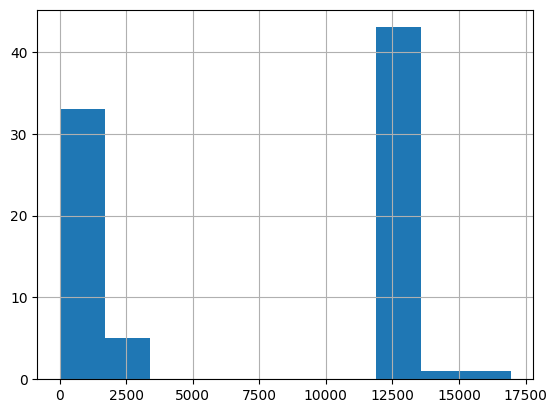

In [51]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [52]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

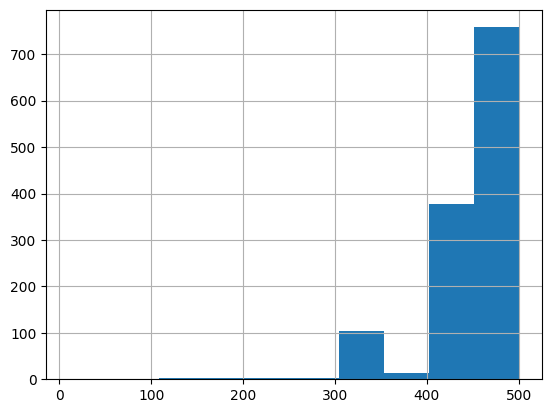

In [53]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [75]:
# imports
import time
import openai

# Define a function that adds a delay to a Embedding API call
def delayed_embedding(delay_in_seconds: float = 1, **kwargs):
    """Delay a completion by a specified amount of time."""

    # Sleep for the delay
    time.sleep(delay_in_seconds)

    # Call the Embeeding API and return the result
    #return openai.Completion.create(**kwargs)
    return openai.Embedding.create(**kwargs)['data'][0]['embedding']




In [ ]:
# Define a function that adds a delay to a Completion API call
def delayed_completion(delay_in_seconds: float = 1, **kwargs):
    """Delay a completion by a specified amount of time."""

    # Sleep for the delay
    time.sleep(delay_in_seconds)

    # Call the Completion API and return the result
    return openai.Completion.create(**kwargs)


# Calculate the delay based on your rate limit
#rate_limit_per_minute = 20
#delay = 60.0 / rate_limit_per_minute

#delayed_completion(
#    delay_in_seconds=delay,
#    model="text-davinci-002",
#    prompt="Once upon a time,"
#)


In [ ]:
import openai
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

openai.api_key = OPENAI_API_KEY

# Calculate the delay based on your rate limit
rate_limit_per_minute = 15
delay = 60.0 / rate_limit_per_minute

df['embeddings'] = df.text.apply(lambda x: delayed_embedding(delay_in_seconds=delay, input=x, engine='text-embedding-ada-002')
)
df.to_csv('processed/embeddings.csv')
df.head()

In [ ]:
df['embeddings']

# Vector Database Implementation

# Pinecone Upsert

In [ ]:
import pinecone

def configure_pinecone(index_name):
  
  # initialize connection to pinecone (get API key at app.pinecone.io)
  pinecone.init(
      api_key="497b372e-6ac8-42c8-be39-c7c756553ab4",
      environment="us-west1-gcp"  # may be different, check at app.pinecone.io
  )

  # check if index already exists (it shouldn't if this is first time)
  if index_name not in pinecone.list_indexes():
      # if does not exist, create index
      pinecone.create_index(
          index_name,
          dimension=len(delayed_embedding(delay_in_seconds=1, input='some text to encode', engine='text-embedding-ada-002')),
          metric='cosine',
          metadata_config={'indexed': ['channel_id', 'published']}
      )
  # connect to index
  index = pinecone.Index(index_name)
  # view index stats
  index.describe_index_stats()
  return index

In [ ]:
from tqdm.auto import tqdm
import datetime
from time import sleep

index_name = 'openai-dbd-website'

def pinecone_upsert(new_data):
  
  print(len(new_data))
  
  index = configure_pinecone(index_name)
  
  batch_size = 100  # how many embeddings we create and insert at once

  for i in tqdm(range(0, len(new_data), batch_size)):
      # find end of batch
      i_end = min(len(new_data), i+batch_size)
      meta_batch = new_data[i:i_end]
      # get ids
      ids_batch = [x['id'] for x in meta_batch]
      # get texts to encode
      texts = [x['text'] for x in meta_batch]
      # create embeddings (try-except added to avoid RateLimitError)
      
      # call delayed_embedding here
      
      #try:
      #    res = openai.Embedding.create(input=texts, engine=embed_model)
      #except:
      #    done = False
      #    while not done:
      #        sleep(5)
      #        try:
      #            res = openai.Embedding.create(input=texts, engine=embed_model)
      #            done = True
      #        except:
      #            pass
      #embeds = [record['embedding'] for record in res['data']]
      
      # cleanup metadata
      meta_batch = [{
          'id': x['id'],
          'title': x['title'],
          'text': x['text'],
          'url': x['url'],
          'source': x['source']
      } for x in meta_batch]
      to_upsert = list(zip(ids_batch, embeds, meta_batch))
      
      # upsert to Pinecone
      index.upsert(vectors=to_upsert)
      
  return index

In [ ]:

# Upsert all the dataframe embeddings to pinecone with metadata included
index = pinecone_upsert(df)


# Pinecone Retrieve

In [ ]:
limit = 3750

def pinecone_retrieve(query, limit):
    res = openai.Embedding.create(
        input=[query],
        engine="text-embedding-ada-002"
    )

    # retrieve from Pinecone
    xq = res['data'][0]['embedding']

    # get relevant contexts
    res = index.query(xq, top_k=5, include_metadata=True)
    contexts = [
        x['metadata']['text'] for x in res['matches']
    ]

    # build our prompt with the retrieved contexts included
    prompt_start = (
        "Responda a Pergunta baseado no contexto abaixo. Seja Simpática, perspicaz, com um leve toque de humor e acrescente mais informações a sua resposta do que somente a resposta em si. No final pergunte se pode ajudar o usuario com mais alguma coisa, variando essa sentença a cada vez que falar com ele para outras similares. Se não for possível idenificar a resposta no contexto enviado, responda educadamente que não sabe a resposta exata para essa pergunta.\n\n"+
        "Contexto:\n"
    )
    prompt_end = (
        f"\n\nPergunta: {query}\nResposta:"
    )
    # append contexts until hitting limit
    for i in range(0, len(contexts)):
        if len("\n\n---\n\n".join(contexts[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts[:i-1]) +
                prompt_end
            )
            break
        elif i == len(contexts)-1:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts) +
                prompt_end
            )
    return prompt

In [ ]:
def openai_complete(prompt):
    # query text-davinci-003
    res = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        temperature=1,
        max_tokens=1000,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res['choices'][0]['text'].strip()

In [ ]:
def answer_question(question,debug=False):

    limit = 3750

    prompt = pinecone_retrieve(query=query, limit=limit)
    
    answer = openai_complete(prompt)

    # If debug, print the raw model response
    if debug:
        print("Prompt:\n" + prompt)
        print("\n\n")

    return answer

In [ ]:
query = "Qual o horario de funcionamento da Biblioteca Central?"

answer = answer_question(index, query, debug=True)

print(answer)

# Memory Based Implementation

In [31]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,blog authors maddie. Maddie Hall - OpenAI ...,175,"[-0.012958061881363392, -0.006103983614593744,..."
1,blog authors tom. Tom Brown - OpenAI ...,228,"[-0.0053874170407652855, -0.009962032549083233..."
2,blog openai scholars 2019 final projects. Op...,492,"[0.0019150723237544298, -0.0070442273281514645..."
3,"In this project, I used curiosity-driven explo...",478,"[-0.0067560747265815735, 0.0004431474662851542..."
4,Results revealed that the optimal RL policies ...,499,"[-0.012868616729974747, 0.0029640409629791975,..."


In [32]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

'No, you are not allowed to publish model outputs to Twitter without a human review. You must manually review each generation before sharing or while streaming, and indicate that the content is AI-generated in a way no user could reasonably miss or misunderstand.'

In [33]:
answer_question(df, question="What day is it?", debug=False)

"I don't know."

In [34]:
answer_question(df, question="What is our newest embeddings model?")

'The newest embeddings model is text-embedding-ada-002.'